In [27]:
import pandas as pd
import numpy as np
import configparser
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
import time
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load credentials from config file
config = configparser.ConfigParser()
config.read('pyalgo.cfg')

consumer_id = config['ssi']['ConsumerID']
consumer_secret = config['ssi']['ConsumerSecret']
private_key = config['ssi']['PrivateKey']

In [3]:
# Step 1: Request access token
def get_access_token(consumer_id, consumer_secret, private_key):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    headers = {"Content-Type": "application/json"}
    data = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret,
        "privateKey": private_key
    }
    res = requests.post(url, json=data, headers=headers)
    res.raise_for_status()
    response = res.json()

    # Extract access token from response
    if "data" in response and "accessToken" in response["data"]:
        return response["data"]["accessToken"]
    else:
        raise ValueError("Access token not found in response:", response)

# Step 2: Get stock price using access token
def get_stock_price(symbol, token, start_date, end_date):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyStockPrice"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
        "Symbol": symbol,
        "FromDate": start_date,
        "ToDate": end_date,
        "Market": "HOSE",
        "PageIndex": "1",
        "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [4]:
# Define token
token = get_access_token(consumer_id, consumer_secret, private_key)

In [5]:
stock = pd.DataFrame(columns=['TradingDate', 'ClosePrice'])

# Historical data

In [6]:
symb = 'VCB'
date = datetime.today()

for i in range(20):
    end_date = date.strftime("%d/%m/%Y")
    start_date = (date - timedelta(days=30)).strftime("%d/%m/%Y")
    data = get_stock_price(symb, token, start_date, end_date)
    df = pd.DataFrame(data['data'])

    # Ensure correct types
    df['TradingDate'] = pd.to_datetime(df['TradingDate'], dayfirst=True)
    df['ClosePrice'] = pd.to_numeric(df['ClosePrice'], errors='coerce')
    
    df1 = df.loc[df['Symbol'] == symb, ['TradingDate', 'ClosePrice']]

    # Append to master DataFrame
    stock = pd.concat([stock, df1], ignore_index=True)

    # Adjust date back
    date -= timedelta(days=31)

    # Wait before the next request to respect rate limit
    time.sleep(3)  

/tmp/ipykernel_3024/3452342173.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock = pd.concat([stock, df1], ignore_index=True)


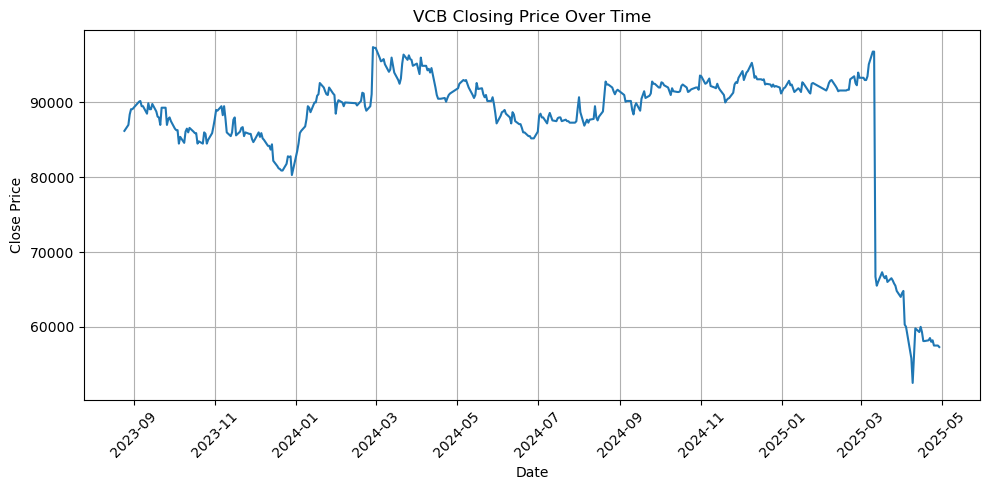

In [7]:
# Sort by trading date
stock = stock.sort_values('TradingDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock['TradingDate'], stock['ClosePrice'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{symb} Closing Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
stock

# Realtime data

In [ ]:
# Get realtime stock price and info
def get_rt_stock_price(symbol, token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IntradayOhlc"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
    "symbol": symbol,
    "FromDate": datetime.today().strftime("%d/%m/%Y"),
    "ToDate": datetime.today().strftime("%d/%m/%Y"),
    "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [ ]:
rt_stock = get_rt_stock_price('GAS', token)

In [ ]:
rt_stock = pd.DataFrame(data['data'])
rt_stock

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(rt_stock['Time'], rt_stock['Close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'GAS Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
t = None
while True:
    rt = get_rt_stock_price('GAS', token)
    if t == None or rt['data'][0]['Time'] != t:
        print(rt['data'][0])
    t = rt['data'][0]['Time']
    time.sleep(2)

In [ ]:
fig = go.FigureWidget()
fig.add_scatter()
fig

In [ ]:
times = list()
prices = list()

for _ in range(75):
    rt = get_rt_stock_price('GAS', token)
    t = rt['data'][0]['Time']
    times.append(t)  
    price = rt['data'][0]['Close']
    prices.append(int(price))
    fig.data[0].x = times  
    fig.data[0].y = prices  
    time.sleep(2)

# VN Stock

In [18]:
from vnstock import Vnstock

symbol = 'VCB'
stock = Vnstock().stock(symbol=symbol, source='VCI')
stk = stock.quote.history(start='2022-01-01', end=datetime.today().strftime("%Y-%m-%d"), to_df=True)
stk.tail()

,time,open,high,low,close,volume
822,2025-04-24,58.2,58.6,58.0,58.2,1861200
823,2025-04-25,58.2,59.0,57.5,57.5,3682000
824,2025-04-28,57.7,58.3,57.5,57.5,1654600
825,2025-04-29,57.7,58.5,57.3,57.3,2432200
826,2025-05-05,57.5,58.0,57.1,57.3,1105900


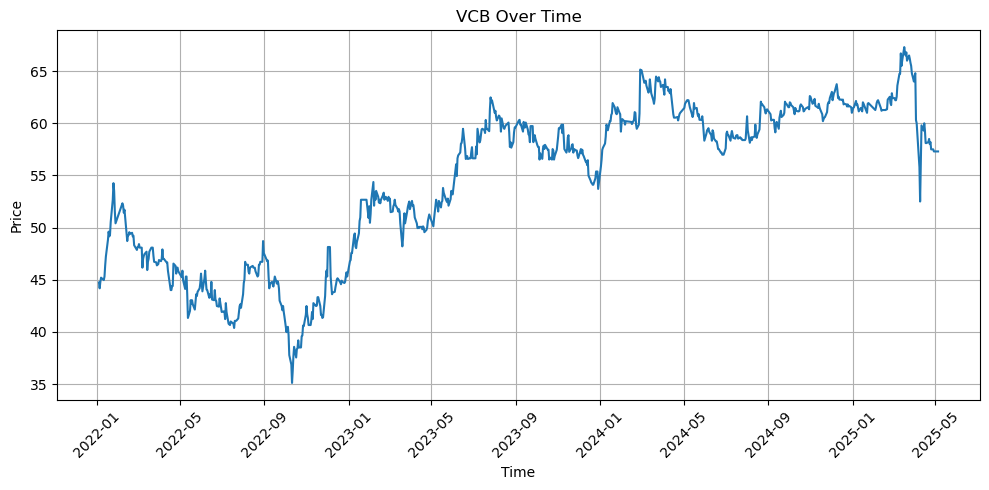

In [19]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(stk['time'], stk['close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{symbol} Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Differencing

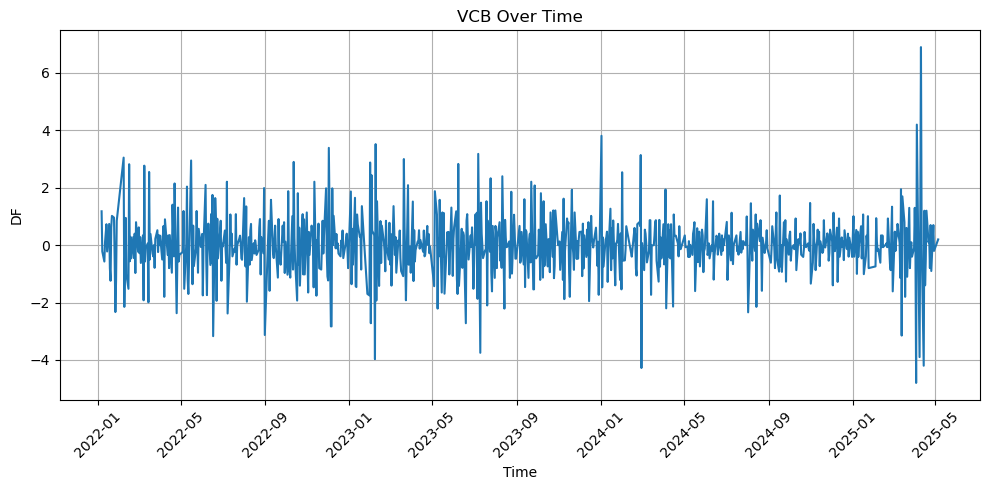

In [25]:
stk['df'] = stk['close'].diff().diff()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stk['time'], stk['df'])
plt.xlabel('Time')
plt.ylabel('DF')
plt.title(f'{symbol} Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
model = ARIMA(stk['df'], order=(3, 2, 3))
model_fit = model.fit()

# Forecast 
forecast = model_fit.forecast(steps=20)

Non-invertible starting MA parameters found. Using zeros as starting parameters.


In [35]:
# Rescale
forecast_cumsum_1 = forecast.cumsum()          # Từ diff2 → diff1
last_diff_1 = stk['close'].diff().iloc[-1]             # diff1 cuối cùng

forecast_diff_1 = forecast_cumsum_1 + last_diff_1

forecast_cumsum_2 = forecast_diff_1.cumsum()   # Từ diff1 → price
last_value = stk['close'].iloc[-1]                     # Giá gốc cuối cùng

forecast_price = forecast_cumsum_2 + last_value
print(forecast_price)

827    57.242703
828    57.146576
829    57.086444
830    57.010769
831    56.926581
832    56.845135
833    56.758799
834    56.666852
835    56.573505
836    56.475008
837    56.373465
838    56.267360
839    56.158174
840    56.044025
841    55.926812
842    55.804530
843    55.679012
844    55.548332
845    55.414296
846    55.274971
Name: predicted_mean, dtype: float64


# Log return Analysis 

In [9]:
stk['log_return'] = np.log(stk['close'] / stk['close'].shift(1))

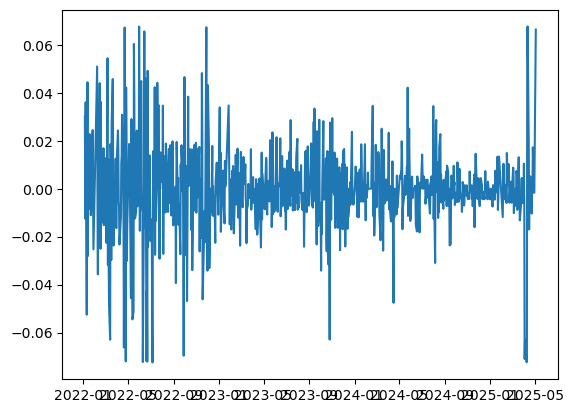

In [12]:
plt.plot(stk['time'], stk['log_return'])

In [27]:
stock.quote.intraday(symbol='VCB').tail(20)

,time,price,volume,match_type,id
80,2025-04-29 14:28:55+07:00,57500.0,2000,Sell,293049440
81,2025-04-29 14:28:57+07:00,57500.0,2000,Sell,293049557
82,2025-04-29 14:29:00+07:00,57500.0,2000,Sell,293049649
83,2025-04-29 14:29:00+07:00,57600.0,100,Buy,293049692
84,2025-04-29 14:29:02+07:00,57500.0,1800,Sell,293049750
85,2025-04-29 14:29:02+07:00,57500.0,2000,Sell,293049855
86,2025-04-29 14:29:17+07:00,57600.0,200,Buy,293050722
87,2025-04-29 14:29:19+07:00,57500.0,1500,Sell,293050887
88,2025-04-29 14:29:24+07:00,57500.0,1500,Sell,293051323
89,2025-04-29 14:29:25+07:00,57600.0,600,Buy,293051389


In [ ]:
while True:

In [12]:
import requests

TOKEN = '8092343811:AAFMv0H66W0B1qzvwwoI5BNmCdMyC3rrHHk'
url = f"https://api.telegram.org/bot{TOKEN}/getUpdates"

response = requests.get(url)
print(response.json())

{'ok': True, 'result': [{'update_id': 681663065, 'message': {'message_id': 2, 'from': {'id': 817649025, 'is_bot': False, 'first_name': 'Thang', 'last_name': 'Winston', 'language_code': 'en'}, 'chat': {'id': 817649025, 'first_name': 'Thang', 'last_name': 'Winston', 'type': 'private'}, 'date': 1745911537, 'text': 'alo'}}]}


In [13]:
def send_telegram_message(message, token, chat_id):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": message
    }
    response = requests.post(url, data=payload)
    return response

In [14]:
# Setup
BOT_TOKEN = TOKEN
CHAT_ID = '817649025'

# Send a test message
send_telegram_message("Hello from Jupyter Notebook!", BOT_TOKEN, CHAT_ID)


<Response [200]>

In [25]:
symbol = 'VCB'

while True: 
    stk = stock.quote.intraday(symbol=symbol, to_df=True)
    last_buy = stk[stk['match_type'] == 'Buy'].tail(1)
    last_buy_price = float(last_buy['price'].iloc[0])
    last_sell = stk[stk['match_type'] == 'Sell'].tail(1)
    last_sell_price = float(last_sell['price'].iloc[0])
    send_telegram_message(f"{symbol} Buy: {last_buy_price}   Sell: {last_sell_price}", BOT_TOKEN, CHAT_ID)
    time.sleep(5)

KeyboardInterrupt: 

In [22]:
stk = stock.quote.intraday(symbol='VCB', to_df=True)
last_buy = stk[stk['match_type'] == 'Buy'].tail(1)
float(last_buy['price'].iloc[0])

57700.0